In [1]:
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
os.environ['OMP_NUM_THREADS'] = '2'

### Inputs

In [3]:
# General inputs
geodata= pd.read_csv('../../model/model_versions/v_7/v7_1/hds_model/GeoData.txt', sep= '\t', index_col=0)

st_mary= pd.read_csv('../../geospacial/misc/stmary_seg', header= None)

zonal_stats_NCAMapper= pd.read_csv('./ncamapper_outputs/zonal_statistics_NCAMapper.csv',  index_col=0)

In [4]:
# HDS inputs
fca = pd.read_csv('./hds_outputs/spin_up_timeFCON_DD.txt', sep= '\t', skiprows=1, index_col=0)

cilv= pd.read_csv('./hds_outputs/spin_up_timeCILV_DD.txt', sep= '\t', skiprows=1, index_col=0)

In [5]:
# NCAMapper inputs
min_ca_path = './ncamapper_outputs/NCAmapper_output/CA_1_0yr_1.000_mm.tif'
max_ca_path = './ncamapper_outputs/CA_2_2yr_22.400_mm.tif'

In [6]:
# Plot options
num_clusters = 14
barplot_min_year_range= 1981
barplot_max_year_range= 2015
barplot_output_dir= './outputs/'

### Format Inputs

In [7]:
# Parse the DATE column as datetime index
fca.index = pd.to_datetime(fca.index)
cilv.index = pd.to_datetime(cilv.index)

# Convert the index to integers
geodata.index = geodata.index.astype(int)
zonal_stats_NCAMapper.index = zonal_stats_NCAMapper.index.astype(int)

# Convert the column headers to integers
fca.columns = fca.columns.astype(int)
cilv.columns = cilv.columns.astype(int)

In [8]:
# Convert the values in the DataFrame to a list of integers
st_mary_list = st_mary[0].astype(int).tolist()

In [9]:
# Drop columns in `fca` that have headers found in `st_mary_list`
fca= fca.drop(columns=fca.columns[fca.columns.isin(st_mary_list)])

cilv= cilv.drop(columns=cilv.columns[cilv.columns.isin(st_mary_list)])

In [10]:
# find frac always contributing
geodata['frac_always_contributing']= 1 - geodata['icatch']

In [11]:
# find total basin area (m2)
milk_area= geodata['area'].sum()

In [12]:
# Replace any occurrence of -9999 with NaN
fca.replace(-9999, np.nan, inplace=True)
cilv.replace(-9999, np.nan, inplace=True)

In [13]:
# Filter rows where the date is between April 1st and September 30th
fca = fca[(fca.index.month >= 6) & (fca.index.month <= 9)]
cilv = cilv[(cilv.index.month >= 6) & (cilv.index.month <= 9)]

In [14]:
# Filter the DataFrame based on the year range
fca_filtered = fca[(fca.index.year >= barplot_min_year_range) & (fca.index.year <= barplot_max_year_range)].copy()
cilv_filtered = cilv[(cilv.index.year >= barplot_min_year_range) & (cilv.index.year <= barplot_max_year_range)].copy()

### icatch Validation

In [15]:
# Calculate the minimum of each column
min_con = fca_filtered.min(axis=0)

# Create a new DataFrame with the results
min_con = pd.DataFrame(min_con, columns=["Minimum_FCA"])

# Merge the 'icatch' column from df_max_per_year onto summary_df based on the index
min_con_merged = min_con.merge(geodata[['icatch']], left_index=True, right_index=True, how='left')

min_con_merged['Min_CA(1-icatch)']= 1 - min_con_merged['icatch']

min_con_merged['Difference (FCA Min -(1-icatch))']=  min_con_merged['Minimum_FCA'] - min_con_merged['Min_CA(1-icatch)']

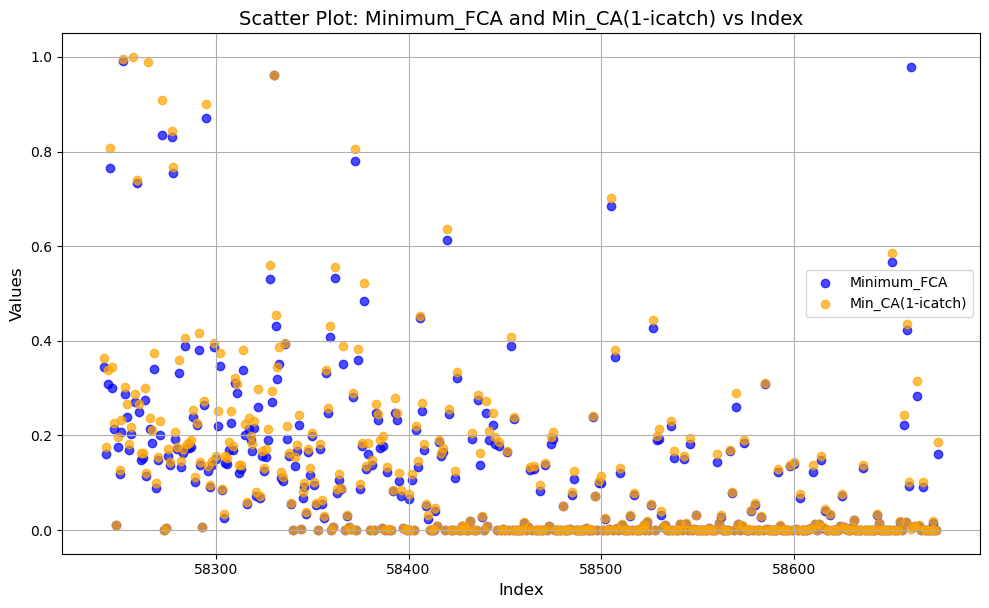

In [16]:
# Ensure the index is numeric
min_con_merged.index = pd.to_numeric(min_con_merged.index)

# Create the scatter plot
plt.figure(figsize=(10, 6.18))
plt.scatter(min_con_merged.index, min_con_merged['Minimum_FCA'], color='blue', label='Minimum_FCA', alpha=0.7)
plt.scatter(min_con_merged.index, min_con_merged['Min_CA(1-icatch)'], color='orange', label='Min_CA(1-icatch)', alpha=0.7)

# Add labels, title, legend, and grid
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Scatter Plot: Minimum_FCA and Min_CA(1-icatch) vs Index', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./outputs/min_fca_icatch.png')

# Show the plot
plt.show()

In [17]:
# Check where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA'
condition = min_con_merged['Min_CA(1-icatch)'] < min_con_merged['Minimum_FCA']

# Filter the rows where the condition is True
rows_with_smaller_values = min_con_merged[condition]

# Print results
if not rows_with_smaller_values.empty:
    print("There are rows where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA':")
else:
    print("No rows found where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA'.")

There are rows where 'Min_CA(1-icatch)' is smaller than 'Minimum_FCA':


In [18]:
rows_with_smaller_values

,Minimum_FCA,icatch,Min_CA(1-icatch),Difference (FCA Min -(1-icatch))
58661,0.979,0.998765,0.001235,0.977765
58508,0.004,0.996284,0.003716,0.000284
58557,0.001,0.999098,0.000902,0.000098
58630,0.007,0.993217,0.006783,0.000217
58449,0.002,0.998302,0.001698,0.000302
58596,0.001,0.999037,0.000963,0.000037
58613,0.012,0.988008,0.011992,0.000008
58624,0.008,0.992117,0.007883,0.000117
58487,0.001,0.999251,0.000749,0.000251
58627,0.003,0.997281,0.002719,0.000281


### Find HDS Max CA

In [19]:
# Initialize a dictionary to store max/min values and their corresponding dates
max_min_values_and_dates = {}

# Iterate over each column
for column in fca_filtered.columns:
    if fca_filtered[column].notna().any():  # Check if the column has non-NaN values
        # Maximum value and corresponding date
        max_value = fca_filtered[column].max()
        max_date = fca_filtered[column].idxmax()
        
        # Minimum value and corresponding date
        min_value = fca_filtered[column].min()
        min_date = fca_filtered[column].idxmin()
        
        # Store in dictionary
        max_min_values_and_dates[column] = {
            'Max Value': max_value, 'Max Date': max_date,
            'Min Value': min_value, 'Min Date': min_date
        }
    else:
        max_min_values_and_dates[column] = {
            'Max Value': None, 'Max Date': None,
            'Min Value': None, 'Min Date': None
        }

# Convert the dictionary into a DataFrame for better visualization
max_min_values_df = pd.DataFrame(max_min_values_and_dates).T

In [20]:
# Initialize 'Max cilv' and 'Min cilv' columns in max_min_values_df
max_min_values_df['Max cilv'] = None
max_min_values_df['Min cilv'] = None

# Iterate through each row in max_min_values_df
for idx, row in max_min_values_df.iterrows():
    # Get the column name from the index (which is the same as the column in cilv)
    column_name = idx  # column_name in cilv corresponds to the index in max_min_values_df
    
    # Extract the Max Date and Min Date
    max_date = row['Max Date']
    min_date = row['Min Date']
    
    # If max_date and min_date are valid (not None), find the values in cilv
    if pd.notna(max_date):
        # Find the value corresponding to the Max Date in cilv
        if max_date in cilv.index:
            max_cilv_value = cilv.at[max_date, column_name]
            max_min_values_df.at[idx, 'Max cilv'] = max_cilv_value
    
    if pd.notna(min_date):
        # Find the value corresponding to the Min Date in cilv
        if min_date in cilv.index:
            min_cilv_value = cilv.at[min_date, column_name]
            max_min_values_df.at[idx, 'Min cilv'] = min_cilv_value

### Create Summary DataFrame

In [21]:
 #Create the summary DataFrame
summary_df = pd.DataFrame({
    'HDS_CA_Max': max_min_values_df['Max Value'],
    'HDS_CA_Min': max_min_values_df['Min Value'],
    'Max_CA_cilv': max_min_values_df['Max cilv'],
    'Min_CA_cilv': max_min_values_df['Min cilv']
})

In [22]:
# Merge NCAMapper results
merged_df = zonal_stats_NCAMapper.merge(summary_df, left_index=True, right_index=True)

In [23]:
merged_df = merged_df.merge(geodata[['frac_always_contributing', 'SLC_62','area','icatch']], left_index=True, right_index=True, how='left')

In [24]:
# Convert all columns in merged_df to numeric, forcing errors to NaN
merged_df = merged_df.apply(pd.to_numeric, errors='coerce')

In [25]:
# Replace zero values in the 'icatch' column with a very large number to account for divide by 0
merged_df['icatch'] = merged_df['icatch'].replace(0, 1e12)

# Find input precipitation required to fill depressions to this state
merged_df['P_input']= ((merged_df['Max_CA_cilv'] * 10**6) /(merged_df['area']*merged_df['icatch'])) * 1000 # convert m to mm

mean_P_depth= merged_df['P_input'].mean()
median_P_depth= merged_df['P_input'].median()
max_P_depth= merged_df['P_input'].max()

In [26]:
merged_df

,NCAMapper_FCA_0.010mm,NCAMapper_FCA_3.530mm,NCAMapper_FCA_8.040mm,NCAMapper_FCA_13.750mm,NCAMapper_FCA_23.200mm,NCAMapper_FCA_46.790mm,NCAMapper_FCA_194.870mm,HDS_CA_Max,HDS_CA_Min,Max_CA_cilv,Min_CA_cilv,frac_always_contributing,SLC_62,area,icatch,P_input
58242,0.202681,0.369737,0.514982,0.619474,0.700077,0.762060,0.847350,0.713,0.344,2.611,0.106,0.362830,0.053234,1.750165e+08,0.637170,23.413845
58243,0.149757,0.301199,0.483547,0.678319,0.765344,0.870606,0.979163,0.770,0.161,6.142,0.267,0.174972,0.081200,2.952909e+08,0.825028,25.211057
58244,0.312902,0.336041,0.379605,0.446120,0.536529,0.664181,0.993247,0.829,0.309,1.072,0.038,0.339217,0.089438,3.612230e+07,0.660783,44.911831
58245,0.767147,0.777641,0.794302,0.826343,0.952105,0.994159,1.001769,0.964,0.765,0.023,0.005,0.806693,0.051981,7.746500e+06,0.193307,15.359397
58246,0.304195,0.310906,0.318776,0.353674,0.383142,0.938941,0.999402,0.949,0.300,0.178,0.012,0.345393,0.131132,1.017080e+07,0.654607,26.735261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58671,0.000000,0.000000,0.000000,0.000331,0.003167,0.003421,0.750412,0.112,0.000,8.825,0.602,0.000000,0.264501,3.860121e+08,1.000000,22.861978
58672,0.017659,0.021398,0.024013,0.041272,0.053878,0.064716,0.183598,0.074,0.015,32.566,1.027,0.019354,0.236104,9.586554e+08,0.980646,34.640937
58673,0.000028,0.000076,0.000205,0.000451,0.001495,0.003497,0.010504,0.051,0.000,5.529,0.283,0.000000,0.287069,2.876408e+08,1.000000,19.221891
58674,0.000000,0.000009,0.003166,0.014940,0.020332,0.022615,0.986334,0.197,0.000,1.468,0.122,0.000000,0.112770,2.727878e+08,1.000000,5.381472


In [27]:
# Calculate statistics for P column
p_column = merged_df['P_input']

# Calculate the required statistics
statistics = {
    'Value (mm)': [
        p_column.min(),
        p_column.quantile(0.05),
        p_column.quantile(0.25),
        p_column.median(),
        p_column.quantile(0.75),
        p_column.quantile(0.95),
        p_column.max(),
    ]
}

# Create a DataFrame with 'Statistic' as the index
stats_df = pd.DataFrame(statistics, index=['Min', 'Q5', 'Q25', 'Q50 (Median)', 'Q75', 'Q95', 'Max'])

In [28]:
stats_df

,Value (mm)
Min,0.000000
Q5,3.526378
Q25,8.041680
Q50 (Median),13.725900
Q75,23.196780
Q95,46.789873
Max,194.874347


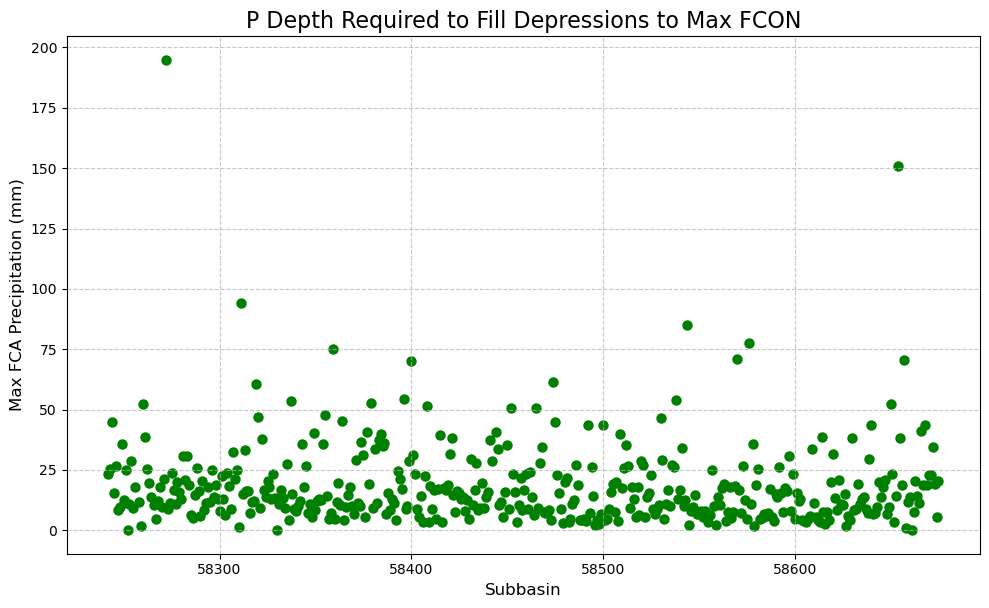

In [29]:
plt.figure(figsize=(10, 6.18))
plt.scatter(merged_df.index, merged_df['P_input'],  color='green', linewidth=1.5)
plt.title('P Depth Required to Fill Depressions to Max FCON', fontsize=16)
plt.xlabel('Subbasin', fontsize=12)
plt.ylabel('Max FCA Precipitation (mm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./outputs/max_fca_P.png')

# Show the plot
plt.show()

### Plot CA Comparison

In [30]:
# Add a column for 'area' * 'SLC_62'
merged_df['depression_area'] = merged_df['area'] * merged_df['SLC_62']

# Sort the DataFrame by 'area' and 'area * SLC_62'
# df_sorted = merged_df.sort_values(by=['area', 'depression_area', 'P_input'], ascending=[False, False, False])
df_sorted = merged_df.sort_values(by=['P_input'], ascending=[False])

# Drop rows with missing values
# df_sorted_clean = df_sorted.dropna(subset=['area', 'depression_area', 'P_input']).copy()
df_sorted_clean = df_sorted.dropna(subset=['P_input']).copy()

# Prepare the data for clustering

# clustering_data_multi_clean = df_sorted_clean[['area', 'depression_area', 'P_input']].to_numpy()
clustering_data_multi_clean = df_sorted_clean[['P_input']].to_numpy()

# Initialize the scaler
scaler = StandardScaler()

# Standardize the data for better clustering
clustering_data_multi_scaled = scaler.fit_transform(clustering_data_multi_clean)

# Set environment variable to avoid memory leak on Windows
os.environ["OMP_NUM_THREADS"] = "2"

# Apply KMeans clustering
kmeans_multi = KMeans(n_clusters=num_clusters, random_state=42)
df_sorted_clean['Cluster_Multi'] = kmeans_multi.fit_predict(clustering_data_multi_scaled)

df_sorted_clean['Cluster_Multi']= df_sorted_clean['Cluster_Multi'] + 1 # add 1 to the cluster names


C:\Users\Paul Coderre\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [32]:
# # Reduce the dimensions of the data to 2D using PCA
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(clustering_data_multi_scaled)

# # Add the cluster labels to the reduced data
# df_sorted_clean['PCA1'] = reduced_data[:, 0]
# df_sorted_clean['PCA2'] = reduced_data[:, 1]


# # Create a figure with two subplots
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# # 1. PCA Plot (First subplot)
# scatter = axes[0].scatter(df_sorted_clean['PCA1'], df_sorted_clean['PCA2'], c=df_sorted_clean['Cluster_Multi'], cmap='viridis', s=50)
# axes[0].set_xlabel('PCA1')
# axes[0].set_ylabel('PCA2')
# axes[0].set_title('PCA of Clusters')

# # Add a color bar to indicate cluster labels
# cbar = plt.colorbar(scatter, ax=axes[0])
# cbar.set_label('Cluster')

# # 2. Cluster vs Index Plot (Second subplot)
# axes[1].scatter(df_sorted_clean['P_input'], df_sorted_clean['Cluster_Multi'], marker='o', linestyle='-', color='b')
# axes[1].set_xlabel('Index')
# axes[1].set_ylabel('Cluster')
# axes[1].set_title('Cluster vs P_input')

# # Adjust layout to avoid overlap between subplots
# plt.tight_layout()

# # Show the plots
# plt.show()

In [33]:
# Group by 'Cluster_Multi' and calculate the mean for 'area', 'depression_area', and 'P_input'
# cluster_means = df_sorted_clean.groupby('Cluster_Multi')[['area', 'depression_area', 'P_input']].mean()
cluster_means = df_sorted_clean.groupby('Cluster_Multi')[['P_input']].mean()

# Initialize the scaler
scaler = MinMaxScaler()

# Apply MinMax scaling to the means
cluster_means_normalized = scaler.fit_transform(cluster_means)

# Convert the normalized array back to a DataFrame with the same columns and index
cluster_means_normalized_df = pd.DataFrame(cluster_means_normalized, columns=cluster_means.columns, index=cluster_means.index)

# Round all numeric values to 2 significant figures
cluster_means_normalized_df = cluster_means_normalized_df.applymap(lambda x: round(x, 2))

table_filename = os.path.join(barplot_output_dir, 'cluster_info.csv')
cluster_means_normalized_df.to_csv(table_filename)

C:\Users\Paul Coderre\AppData\Local\Temp\ipykernel_34120\1881111275.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cluster_means_normalized_df = cluster_means_normalized_df.applymap(lambda x: round(x, 2))


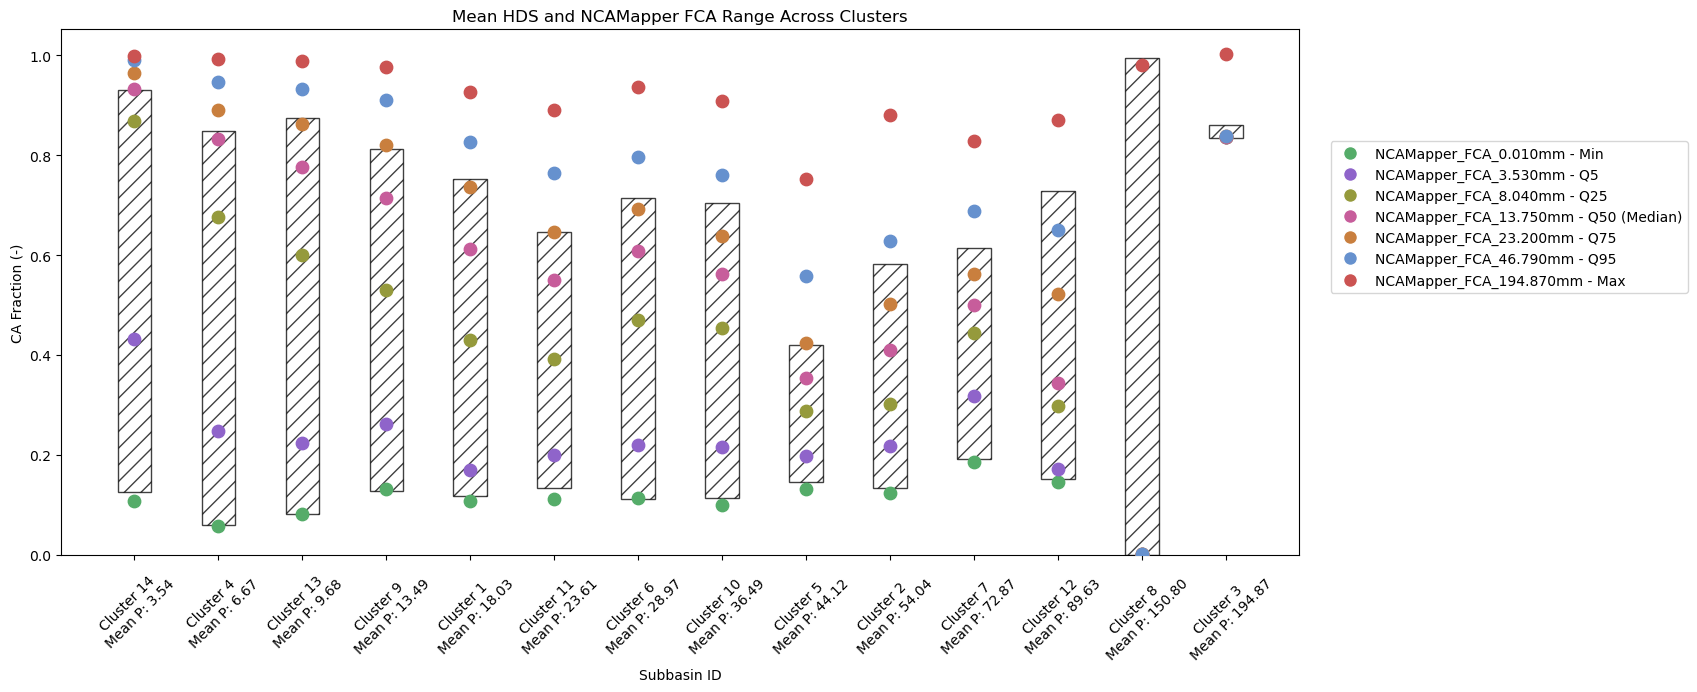

Plot of Mean CA Fraction Ranges by Cluster with NCAMapper Dots and HDS Range Saved.


In [51]:
# Sort the df_sorted_clean by the 'Cluster_Multi' column
df_sorted_clean_sorted = df_sorted_clean.sort_values(by='Cluster_Multi')

# Define the colors for NCAMapper dots
ncamapper_colors = ["#55ac69", "#8f64ca", "#959a3c", "#c75d9b", "#c97f3e", "#6691ce", "#cb5352"]

# Define hatch pattern for the HDS bars
hatch_pattern = '//'  # You can customize the pattern if needed

# Manually define the list of colors for the NCAMapper columns (ensure it has enough colors)
ncamapper_columns = [col for col in df_sorted_clean_sorted.columns if 'NCAMapper' in col]

# Calculate the mean of 'P_input' for each cluster
cluster_means = df_sorted_clean_sorted.groupby('Cluster_Multi')['P_input'].mean()

# Sort the clusters by the mean of 'P_input'
sorted_clusters = cluster_means.sort_values().index

# Create a figure for the combined plot
fig, ax = plt.subplots(figsize=(14, 7))

# Set the positions for the bars based on the sorted clusters
x_positions = np.arange(len(sorted_clusters))  # The positions for each cluster on the x-axis

# Store the legend handles and labels for the NCAMapper columns
ncamapper_handles = []
ncamapper_labels = []

# Loop through each sorted cluster and plot a bar for the mean values of each column
for idx, cluster in enumerate(sorted_clusters):
    # Get all rows corresponding to the current cluster
    cluster_rows = df_sorted_clean_sorted[df_sorted_clean_sorted['Cluster_Multi'] == cluster]
    
    # Calculate the mean values for the cluster
    cluster_mean = cluster_rows.mean()  # Calculate mean of all numeric columns in the cluster
    
    # Bar for HDS CA range with hatch marks but no color
    ax.bar(x_positions[idx], 
           cluster_mean['HDS_CA_Max'] - cluster_mean['HDS_CA_Min'], 
           width=0.4, 
           bottom=cluster_mean['HDS_CA_Min'], 
           color='white',  # No color, just hatch pattern
           alpha=0.75,  # Transparency
           hatch=hatch_pattern,  # Adding hash marks
           label=f'Cluster {cluster} HDS Range',
           edgecolor='black')  # Add black edge to make the bar visible

    # Plot dots for columns with "NCAMapper" in the name
    for i, ncamapper_column in enumerate(ncamapper_columns):
        # Get the corresponding color from the manually defined color list
        dot_color = ncamapper_colors[i % len(ncamapper_colors)]  # Use modulus to loop through colors
        
        # Place dots vertically at the mean value of each NCAMapper column
        ax.scatter(x_positions[idx], 
                   cluster_mean[ncamapper_column], 
                   color=dot_color, 
                   s=80,  # Size of the dots
                   label=f'{ncamapper_column} - {stats_df.index[i]}' if idx == 0 else "",  # Add index value to label
                   zorder=5)

        # Store the legend handles and labels for NCAMapper
        if idx == 0:  # Add the label only once for each NCAMapper column
            ncamapper_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dot_color, markersize=10))
            ncamapper_labels.append(f'{ncamapper_column} - {stats_df.index[i]}')

# Set labels for axes and title
ax.set_xlabel('Subbasin ID')
ax.set_ylabel('CA Fraction (-)')
ax.set_title('Mean HDS and NCAMapper FCA Range Across Clusters')

# Adjust layout to ensure labels don't overlap
plt.tight_layout(pad=4.0)

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Add a legend for both HDS CA range and NCAMapper columns outside the right border of the plot
ax.legend(handles=[ncamapper_handles[0]] + [ncamapper_handles[i] for i in range(1, len(ncamapper_handles))], 
          labels=[ncamapper_labels[0]] + [ncamapper_labels[i] for i in range(1, len(ncamapper_labels))],
          loc='upper left', bbox_to_anchor=(1.02, 0.8))  # Placing the legend outside the right border

# Add the mean P_input value to the x-axis label for each cluster
xtick_labels = [f'Cluster {cluster} \nMean P: {cluster_means[cluster]:.2f}' for cluster in sorted_clusters]
ax.set_xticks(x_positions)  # Ensure that x-tick positions match the bar positions
ax.set_xticklabels(xtick_labels)  # Set the x-tick labels with mean P_input values

# Save the plot
plot_filename = os.path.join(barplot_output_dir, 'mean_cluster_HDS_comparison_sorted.png')
plt.savefig(plot_filename,bbox_inches='tight')
plt.show()

# Optionally, display a message indicating completion
print("Plot of Mean CA Fraction Ranges by Cluster with NCAMapper Dots and HDS Range Saved.")

In [45]:
# Turn 'cluster_means' into a DataFrame
cluster_means_df = cluster_means.reset_index()  # Reset index to convert the Series into a DataFrame

# Rename columns for better clarity
cluster_means_df.columns = ['Cluster_Multi', 'P_input_Mean']  # Assign appropriate column names

# Sort the DataFrame by 'P_input_Mean' in ascending order
cluster_means_df_sorted = cluster_means_df.sort_values(by='P_input_Mean', ascending=True)

cluster_means_df_sorted

,Cluster_Multi,P_input_Mean
13,14,3.536052
3,4,6.667745
12,13,9.676559
8,9,13.493704
0,1,18.029071
10,11,23.606303
5,6,28.965746
9,10,36.493013
4,5,44.124525
1,2,54.041334


In [35]:
# Sort the clusters by the mean of 'P_input'
sorted_clusters = cluster_means.sort_values().index
cluster_means_normalized_df

,P_input
Cluster_Multi,
1,0.08
2,0.26
3,1.00
4,0.02
5,0.21
6,0.13
7,0.36
8,0.77
9,0.05


In [36]:
# Get the total number of rows in merged_df
total_rows = len(merged_df)

# Initialize an empty list to store the results for each row
comparison_results = []

# Get the smaller length between `stats_df` and `ncamapper_columns` to avoid index errors
min_len = min(len(stats_df), len(ncamapper_columns))

# Iterate through the smaller length to avoid going out of bounds
for i in range(min_len):
    # Get the corresponding index (row name) from stats_df
    stat_index = stats_df.index[i]
    stat_value = stats_df['Value (mm)'].iloc[i]  # Using iloc to avoid FutureWarning

    # Loop through each NCAMapper column
    ncamapper_col = ncamapper_columns[i]

    # Calculate the range around HDS_CA_Max (±5%)
    lower_bound = df_sorted_clean_sorted['HDS_CA_Max'] * 0.95  # 5% below
    upper_bound = df_sorted_clean_sorted['HDS_CA_Max'] * 1.05  # 5% above

    # Count rows where NCAMapper value is within the range (lower_bound <= NCAMapper <= upper_bound)
    within_range = ((df_sorted_clean_sorted[ncamapper_col] >= lower_bound) & 
                    (df_sorted_clean_sorted[ncamapper_col] <= upper_bound)).sum()
    
    # Count rows where NCAMapper value is greater than the upper bound (above the range)
    greater_than_range = (df_sorted_clean_sorted[ncamapper_col] > upper_bound).sum()
    
    # Count rows where NCAMapper value is smaller than the lower bound (below the range)
    smaller_than_range = (df_sorted_clean_sorted[ncamapper_col] < lower_bound).sum()
    
    # Calculate percentages
    within_range_percentage = (within_range / total_rows) * 100
    greater_than_range_percentage = (greater_than_range / total_rows) * 100
    smaller_than_range_percentage = (smaller_than_range / total_rows) * 100

    # Add the result as a new row in the list for DataFrame
    comparison_results.append({
        'NCAMapper Depth and ': f"{ncamapper_col} Corresponding to {stat_index}",
        'Smaller Than Max HDS CA Range': smaller_than_range_percentage,
        'Within Max HDS CA Range': within_range_percentage,
        'Greater Than Max HDS CA Range': greater_than_range_percentage
    })

# Create a DataFrame from the results list
comparison_df = pd.DataFrame(comparison_results)

# Set the 'NCAMapper Depth and ' as the index
comparison_df.set_index('NCAMapper Depth and ', inplace=True)

In [37]:
comparison_df

,Smaller Than Max HDS CA Range,Within Max HDS CA Range,Greater Than Max HDS CA Range
NCAMapper Depth and,,,
NCAMapper_FCA_0.010mm Corresponding to Min,98.845266,0.692841,0.000000
NCAMapper_FCA_3.530mm Corresponding to Q5,94.688222,1.385681,3.464203
NCAMapper_FCA_8.040mm Corresponding to Q25,78.290993,10.854503,10.392610
NCAMapper_FCA_13.750mm Corresponding to Q50 (Median),57.736721,21.709007,20.092379
NCAMapper_FCA_23.200mm Corresponding to Q75,33.718245,37.182448,28.637413
NCAMapper_FCA_46.790mm Corresponding to Q95,13.163972,40.877598,45.496536
NCAMapper_FCA_194.870mm Corresponding to Max,2.309469,33.718245,63.510393
